# Reading group: adversarial spheres

Vinay Ramasesh, March 2018 <br>
Comments/questions/errata welcome: ramasesh@berkeley.edu

This notebook is an updated version of one originally written for a [Machine Learning at Berkeley](https://ml.berkeley.edu/) reading group given Spring 2018, covering the 2018 paper [Adversarial Spheres](https://arxiv.org/abs/1801.02774) by Gilmer et al.  In one sentence, this paper highlights the failure of (at least my) low-dimensional intuition when thinking about classifiers in high dimension.  

First, we briefly review adversarial examples, though most present at the discussion were familiar with them.  Then, we discuss some properties of high-dimensional spheres which run counter to low-dimensional intuition.  With that in place, we finally discuss the paper itself, which uses a nice toy model to illustrate a situation in which, unless a classifier is perfect, adversarial examples are likely to exist.

In [1]:
import numpy as np
from scipy.special import gamma, erf
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

### Notation

* $\langle x \rangle$ - the expectation value of the random variable $x$.  
* $\mathcal{S}^n$ - the $n$-sphere, defined by the equation $\sum_{i=0}^n x_i^2 = 1$. The $1$-sphere is a circle, the $2$-sphere is an ordinary sphere, etc.

### Necessary functions

In [2]:
def sphere_sample(dim=3):
    """ Samples from a sphere of the specified dimension uniformly, using the following trick:
    1. Sample 'dim' independent identically distributed Gaussians
    2. Normalize
    """
    point = np.random.randn(dim+1)
    point = point/np.linalg.norm(point, ord=2)

    return point

## Review of adversarial examples
It is now well-known that neural network classifiers which exhibit extremely low test error are susceptible to finely-tuned *adversarial examples* designed to fool the network.  One of the canonical examples is shown below. A neural network which correctly classifies the example on the left fails when a small amount of noise is added.

<img src="https://blog.openai.com/content/images/2017/02/adversarial_img_1.png" height=250>

To my knowledge, the first work to point out this phenomenon was the 2013 paper by Szegedy et al., [Intriguing properties of neural networks](https://arxiv.org/abs/1312.6199).  Since the publication of that work, many ways to find these adversarial examples have been invented; on the other hand, many defenses have attempted to make neural network classifiers less vulnerable to adversarial attacks.  Unfortunately, it seems that as of the time of this reading group, no defense yet exists which is capable of withstanding most attacks.  Also as of this time, there isn't a good understanding in the community of exactly *why* these adversarial examples exist; that is, what property of the classifier makes it misclassify images which are very similar to correctly classified examples?

The literature on adversarial examples is extensive, so we won't repeat the background here.  I want to instead focus on the **(wrong!)** intuition I had regarding the decision boundaries of classifiers which were vulnerable to adversarial examples, which this paper corrected.  Let's focus on a two-dimensional classifier, $f$, which classifies into one of two classses $0$ or $1$; that is, $f:(x,y) \rightarrow [0,1]$.  For ease, let the ground truth be the following: class 0 (white) consists of points such that $y\geq x$, and class 1 (blue) consists of points such that $y < x$:

<img src="groundtruth.png" height=350 width=350>

Now consider a classifier which is imperfect, in that it classifies a narrow strip of points incorrectly.  To be precise, take the classifier $f_1$ to classify points such that $y \geq x + 0.5$ as white, and all other points as blue.  The decision boundary of such a classifier looks like:

<img src="f1.png" height=350 width=350>

where for clarity we've shown the ground-truth decision boundary with a white dotted line.  Though this classifier has errors, for most inputs it is not vulnerable to the same sort of adversarial perturbations we usually think of, because for most inputs $(x,y)$, the distance between the input and the "error region" is large.  To be explicit, we show below three input points $A$, $B$, and $C$ which are correctly classified by $f_1$ as belonging to the *white* class.  We also show the smallest change (Euclidean distance) or perturbation which must be added to those three inputs in order to cause a misclassification.  

<img src="f1adv.png" height=350 width=350>

Of these points, only $C$ is close enough to the classifier's decision boundary to really be considered vulnerable to an adversarial attack.  For points $A$ and $B$, the magnitude of the perturbation required is so large that it cannot really be considered infinitesimal.  Of course, these are all relative statements, but the point stands that the vast majority of points in this situation are very far from the set of incorrectly-labeled points.  This is quite different from the situation seen in the adversarial examples we're familiar with: in those settings, *most* of the input points are vulnerable to adversarial images.  Such behavior cannot be captured by this simple, "clean" decision boundary of $f_1$, so my intuition was that the decision boundaries of neural network classifiers had to look more like the one below (call it $f_2$):

<img src="f2adv.png" height=350 width=350>

In this sort of situation, there are pockets of incorrect classification scattered all throughout the input space.  This was how I assumed the decision boundary had to look like, so that almost any point in input space would be located close to a decision boundary and a small, targeted perturbation would be able to cause a misclassification.  More broadly, this intuition suggested that the flaw lies with the neural network model itself, in that it exhibits a "pocked" decision boundary vulnerable to adversarial examples.  

**The key takeaway of the adversarial spheres paper is that the above intuition is NOT (necessarily) true for classifiers in high-dimensions.  If the data comes from certain high dimensional manifolds (like a sphere), *any* amount of imperfection in the model may be enough to guarantee the existence of adversarial examples.**

To understand the above statement, we must first understand some properties of high-dimensional spheres that are markedly different from their low-dimensional counterparts.  

## 'Strange' properties of high-dimensional spheres

Here, we discuss some strange properties of high-dimensional spheres.  The main one that will be necessary to appreciate the Adversarial Spheres paper is the one we discuss first: that mos of the 'mass' is concentrated around the sphere's equator.  The rest are just for fun (and to show more instances where low-dimensional intuitions falls short), so feel free to skip them if your only interest is understanding the paper.  

### Most of the mass is concentrated around the equator

Because the $N$-sphere with unit radius is defined by the equation 
\begin{equation}
\sum_{i=0}^N x_i^2 = 1,
\end{equation}
as $N$ grows larger and larger, the absolute value of any individual coordinate gets closer and closer to zero.  This is pretty easy to see informally, but we can be slightly more precise.  Imagine randomly sampling a point from the sphere.  Then the values $\{x_i\}$---and their squares $\{x_i^2\}$---become random variables.  By linearity of expectation, 
\begin{equation}
\sum_{i=0}^N \langle x_i^2 \rangle = 1,
\end{equation}
Note that the $x_i$ are not *independent* random variables, but it doesn't matter for the above equation: linearity of expectation value holds regardless of whether the invidual random variables display correlations or not.  By symmetry, all of the $\langle x_i^2 \rangle$ should be equal, and thus $\langle x_i^2 \rangle = 1/(N+1)$.   

Let's check this relation numerically to make sure we're on the right track.

In [3]:
dimensions = np.arange(2,10)
n_samples = 10000

expectations_numeric = np.empty(dimensions.shape)

for ind, dim in enumerate(dimensions):
    avg_xsquared = 0
    for _ in range(n_samples):
        avg_xsquared += sphere_sample(dim=dim)[0]**2
    avg_xsquared /= n_samples
    expectations_numeric[ind] = avg_xsquared
    
# for plot
x_dim = np.linspace(np.min(dimensions), np.max(dimensions), 50)
expectations_analytic = 1/(x_dim + 1)

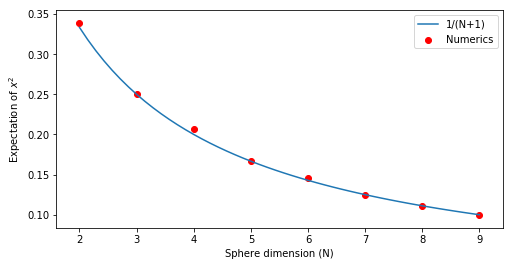

In [4]:
plt.figure(figsize=(8,4))
plt.plot(x_dim, expectations_analytic, label='1/(N+1)')
plt.scatter(dimensions, expectations_numeric, c='red', label='Numerics')
plt.xlabel('Sphere dimension (N)')
plt.ylabel('Expectation of $x^2$')
plt.legend(loc=1);

Great! Our numerics are consistent with the above formula.  Let's be a bit more quantitative.  Specifically, let's ask the question: what *fraction* of points lie within a distance $\sqrt{\epsilon}$ of the equator?  To be precise, we have to specify *which* equator we're talking about.  On any sphere, there are an infinity of equators, each defined by the intersection of the sphere and a plane which contains the origin.  Without loss of generality, we'll take the equator to mean the intersection of the sphere with the plane $x_0 = 0$.  In this case, the set of points within distance $\sqrt{\epsilon}$ from the equator is simply those points on the sphere for which $|x_0| < \sqrt{\epsilon}$, or for which $x_0^2 < \epsilon$.

It turns out that for points uniformly drawn from the $N$-sphere, the distribution of $x_0^2$ (or, by symmetry, and coordinate $x_i^2$) is given by
\begin{equation}
p_{x^2}( \epsilon ) = \frac { 1 } { \sqrt { \pi } } \frac { \Gamma ( N / 2 ) } { \Gamma ( ( N - 1 ) / 2 ) } \frac { ( 1 - \epsilon ) ^ { ( N - 3 ) / 2 } } { \sqrt { \epsilon } },
\end{equation}
for $0 \leq \epsilon \leq 1$, and $\Gamma()$ is [the Gamma function](https://en.wikipedia.org/wiki/Gamma_function). For a derivation, see chapter 9 of [this great book on random matrix theory](https://arxiv.org/abs/1712.07903). 

In [5]:
def pxsquared(y, dim):
    """ returns the pdf of x^2, evaluated at y, where x is one coordinate of a point uniformly 
    sampled from the surface of a dim-sphere"""
    
    return np.power(np.pi, -0.5)*gamma(dim/2)/gamma((dim-1)/2)*np.power(1-y,(dim-3)/2)/np.sqrt(y)*np.heaviside(y,1)*np.heaviside(1-y,1)

Let's do a couple things with this formula.<br>
**First**, let's verify that it matches numerics:

In [6]:
dimensions_to_check = [10, 25, 33]

bin_edges_right = np.linspace(0.01, 1, 99)
bin_edges_left = np.linspace(0, 0.99, 99)
bin_centers = 0.5*(bin_edges_right + bin_edges_left)[1:]

analytic_distributions = {}
numeric_distributions = {}

n_pts_numeric = 100000

for dim in dimensions_to_check:
    
    analytic_distributions[dim] = pxsquared(bin_centers,dim)

    coordinates_squared=np.empty(n_pts_numeric)
    for pt in range(n_pts_numeric):
        sampled_pt = sphere_sample(dim=dim)
        coordinates_squared[pt] = np.power(sampled_pt[0], 2)
    numeric_distributions[dim] = np.histogram(coordinates_squared, bins = bin_edges_right, density = True)[0]

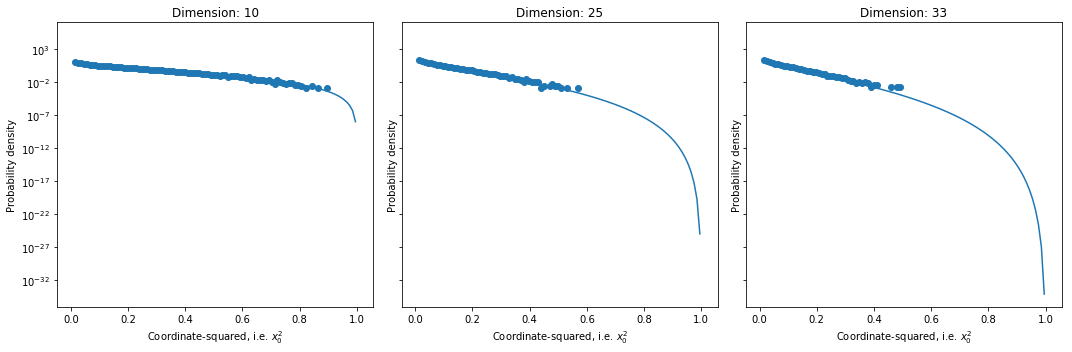

In [7]:
fig, axes = plt.subplots(1, len(dimensions_to_check), figsize = (15,5), sharey = True)
for ind, dim in enumerate(dimensions_to_check):
    axes[ind].set_title(f'Dimension: {dim}')
    axes[ind].set_xlabel('Coordinate-squared, i.e. $x_0^2$')
    axes[ind].set_ylabel('Probability density')
    axes[ind].scatter(bin_centers, numeric_distributions[dim])
    axes[ind].semilogy(bin_centers, analytic_distributions[dim])
plt.tight_layout()

Playing around with the above cells should convince you that our formula matches the numerics quite well.  Even in the above plots, one can see how the mass concentrates around the equator:  for dimensions 25 and 33, hardly any of the sampled points exceed 0.5!  

**Second**, let's get a simplified version of the above formula that should work in the limit of large $N$.  Instead of working with $\epsilon$ directly, let's scale $\epsilon$ by $N$ to find the pdf of the quantity $y\equiv N\epsilon$.  Using the definition that $(1+x/N)^N$ approaches $e^x$ in the limit of large $N$, you should be able to work out (up to normalization, for which I had to cheat and use [WolframAlpha](https://www.wolframalpha.com))  that the pdf of $y$ is given by 
\begin{equation}
p_Y(y) = \frac { 1 } { \sqrt { 2 \pi y } } e ^ { - y / 2 }
\end{equation}
Notice that this function is independent of $N$; the only place $N$ comes into play is in the scaling $y = N\epsilon$.  To be clear, if we are in , say, $N = 10$ dimensions, and want to know the fraction of points which have $x_0^2 < \epsilon$, we integrate the above distribution from $0$ to $10\epsilon$.  

Let's test that this pdf is a good approximation to the true pdf 'pxsquared' from above.

In [8]:
def pxsquared_asymptotic(eps, dim):
    """ probability density function of x^2 """
    return np.exp(-dim*eps/2)/np.sqrt(2*np.pi*dim*eps)*dim

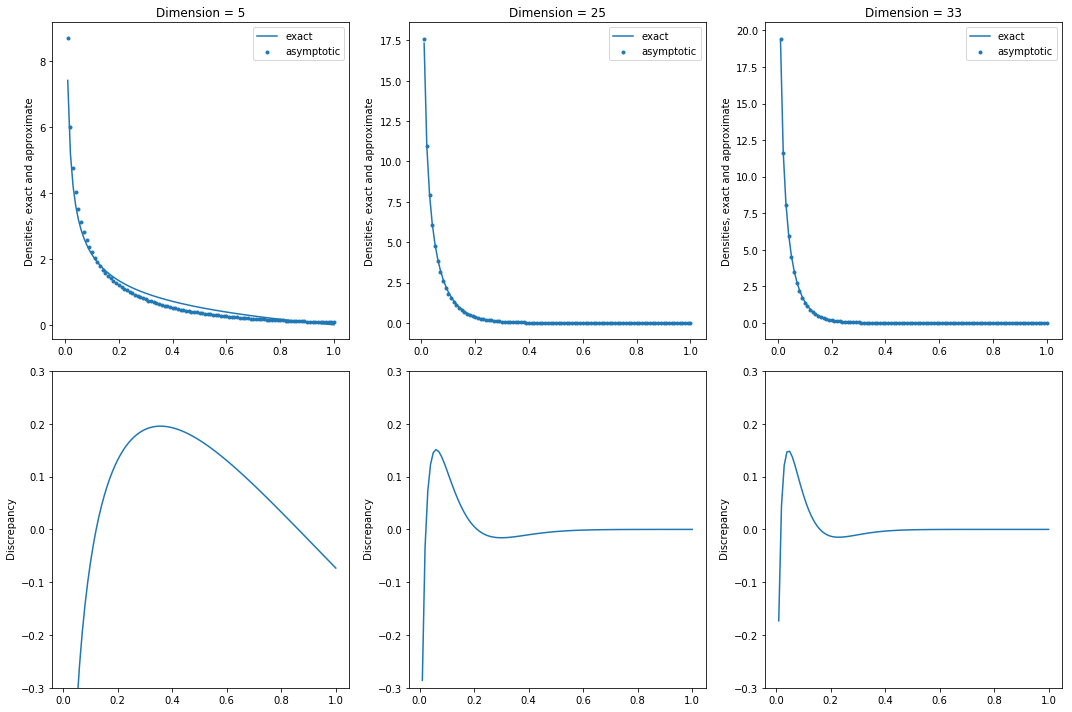

In [9]:
test_dims = [5, 25, 33]

fig, axes = plt.subplots(2, len(dimensions_to_check), figsize = (15,10), sharey = False)
x = np.linspace(0.01,1,100)
   
for ind, test_dim in enumerate(test_dims):
    exact_pdf = pxsquared(x, test_dim)
    asymptotic_pdf = pxsquared_asymptotic(x, test_dim)
    
    axes[0,ind].plot(x, exact_pdf, label = 'exact')
    axes[0,ind].scatter(x, asymptotic_pdf, label = 'asymptotic', marker = '.')
    axes[0,ind].set_title(f"Dimension = {test_dim}")
    axes[0,ind].set_ylabel("Densities, exact and approximate")
    axes[0,ind].legend(loc = 1)
    
    axes[1,ind].plot(x, (exact_pdf - asymptotic_pdf))
    axes[1,ind].set_ylabel(" Discrepancy")
    axes[1,ind].set_ylim(-0.3,0.3)
    
plt.tight_layout()

So, we can see that for $N = 5$, the approximate formula is not such a great approximation to the exact formula, but with $N$ even as low as 25, the approximation gets to be quite good.  In the adversarial spheres paper, the lowest dimension used looks to be $N=10$, so we are pretty safe in gaining intuition from this simplified formula.

Let's do that.  Fixing $\epsilon$ to be 0.01, (remember $\epsilon \in [0,1]$), how much probability mass lies in the region where $x_0^2 < \epsilon$, as a function of dimension? For this we just need the formula
\begin{equation}
\int _ { 0 } ^ { a } \frac { \exp \left( - \frac { x } { 2 } \right) } { \sqrt { 2 \pi x } } d x = \operatorname { erf } \left( \frac { \sqrt { a } } { \sqrt { 2 } } \right) = \operatorname { erf } \left( \frac { \sqrt { N \epsilon } } { \sqrt { 2 } } \right),
\end{equation}
where $\operatorname {erf}()$ is the [error function](https://en.wikipedia.org/wiki/Error_function).  


In [10]:
def CDF_xsq_asymptotic(eps, dim):
    """ returns the probability that x^2 < eps for a randomly sampled point from a dim-sphere"""
    return erf(np.sqrt(dim*eps/2))

In [11]:
CDF_xsq_asymptotic(0.155, 20)

0.9217077058535901

Playing around with the above cells a little bit, we can see that as the dimension grows, an insane fraction of the sphere's mass concentrates in the region $x_0^2 < \epsilon$.  The below table lists some representative values:

|Dimension   |  5 | 10  | 50  | 100 | 500 | 1000 |
|---|---|---|---|---|---|---|
| $\epsilon = 0.01$ | 0.18  | 0.25  | 0.52  | 0.68  | 0.97 | 0.998 |
| $\epsilon = 0.001$   |  0.06 | 0.08  |  0.18 |  0.25 | 0.52 | 0.68 |

Remember that while a 1000-dimensional sphere might sound unimaginably high, this dimension is not crazy compared to the dimensionality of input spaces for machine learning tasks: MNIST consists of points in a 784-dimensional space, whereas CIFAR is 1024-dimensional (though we should caveat that the data itself may lie on a much lower-dimensional manifold within the full input space).  **For such a sphere, the number of points which lie in the strip $x_0^2 < \epsilon = 0.01$ outnumbers the other points by five hundred to one!**  This is a clear indication that our low-dimensional intuition is failing spectacularly here.

Here's a visualization, due to [Marc Khoury](https://marckhoury.github.io/counterintuitive-properties-of-high-dimensional-space/), which captures this property of the spheres:
<img src="https://marckhoury.github.io/assets/images/Figure7.png">
In fact, in Marc's post, he uses this to illustrate a different property of high-dimensional spheres, but it works equally well for this property.  

However, as you might imagine for an attempted visualization of a thousand-plus dimensional object in two dimensions, this visualization cannot be taken too seriously. In particular, it shows the sphere as have special points (such as the corners), whereas in reality, every point on the sphere should look identical.  Further, it implies that most of the volume contained in the sphere lies near the core, whereas in reality, most of the sphere's volume lies near the surface.  This concentration of volume close to the surface in fact happens more strongly in high dimensions.

Despite the above two flaws, the visualization of a *spiky* sphere in high dimensions is good to keep in your mind, if only as a mnemonic to remember the takeaway from this section: most of a high-dimensional sphere's points is concentrated near the equator.

### Corollary: Spherical caps of fixed area fraction creep closer to the equator as the dimension increases

A consequence of the fact that most of a high-dimensional sphere's points concentrate near the equator is that the 'caps' of a sphere start to extend closer and closer to the equator as the dimension of the sphere increases.  The figure below illustrates what we mean by a cap:

<img src="https://upload.wikimedia.org/wikipedia/commons/d/d4/Spherical_Cap.svg" height=300 width = 300>

Let's say we want to consider a cap, oriented along the $x_0$ direction, which covers 1% of the sphere's surface area. By oriented along the $x_0$ direction, we mean that the cap consists of all of the points on the unit sphere such that $x_0 > 1 - h$ for some value $h$.  In a two-dimensional sphere, the area of a spherical cap ([wiki](https://en.wikipedia.org/wiki/Spherical_cap#Volume_and_surface_area)) is $2\pi r h$, so the fraction of the unit sphere it contains is simply $h/(2r)$.  Thus, on a 2-sphere $h = 0.02$ would result in a cap covering 1% of the total surface.  However, based on the table we made in the previous section, in 1000 dimensions $h = 0.9$ would result in a 1% cap.  Even though the cap contains so few points, it gets very close to the equator in high dimensions.  

For another concrete example, the Arctic circle covers roughly 4% of the earth's surface.  If the earth were a 20-dimensional sphere, the an equivalent area would extend down to the Tropic of Cancer.  

## The Adversarial Spheres paper

With this background in place, we are ready to understand the main result of the adversarial spheres paper.  In the paper, a "simple" two-class classification task is set up: class 1 consists of all points on an $n$-sphere of unit radius; class 2 consists of all points on a $n$-sphere of radius 1.3.  (Why 1.3?  In the paper it's stated that that was an arbitrary choice, and that other values of the radius were not investigated).  There are a couple nice features of this setup:

1. The data manifolds are explicitly specified and easily to sample from (see [this post](https://nbviewer.jupyter.org/github/ramasesh/bhcalcs/blob/master/Properties%20of%20Haar-Random%20quantum%20states.ipynb) if you haven't seen the trick for sampling from an $n$-sphere), and 
2. There is a known decision boundary that will work with perfect accuracy, and a network can be designed which can express such a boundary.

Now imagine that we take $n$, the dimensionality of the problem, to be very large and then train some classifier on this problem, such that it achieves very low (but not zero!) error rate, such that there is small subset of points (the "error set") on both spheres which are classified incorrectly.  Focusing on the inner sphere, and thinking back to the intuition presented in the first section, we might imagine two types of decision boundaries for this classifier:
1. one in which the error set is concentrated in one (or a few) spherical caps, or
2. one in which the error set is dispersed throughout the surface of the sphere. 
If we were in low dimensions, we might think that the first type of decision boundary is not vulnerable to adversarial perturbations, while the second type is.  However, the properties of high-dimensional spheres discussed in the previous section tell us that this is not the case!  Even if all of the error is contained in a single spherical cap, which is perhaps the "nicest" error set we can imagine, we will still find adversarial examples.  

To understand why this is the case, let's apply the two facts we discussed last section about high-dimensional spheres.  Let $x_0$ be the coordinate on the sphere in the direction of the cap.  The first property tells us that in high dimensions, the overwhelming majority of points lie on the equator of the sphere, i.e. with coordinate $x_0\approx 0$.  Second, as the dimension increases, for a fixed classifier error-rate, the error set extends further and further down from the pole $x_0 = 1$ to the equator $x_0 = 0$.  Thus, almost every correctly-classified point, which lies on the equator, can be perturbed by a tiny amount in the $x_0$ direction and reach the error set.  

**This is the key point of the paper, which is worth restating:  in high dimensions, for a spherical data manifold, *any* amount of test error implies the existence of adversarial perturbations, even if the classifier has the cleanest decision boundary imaginable.** 

This theoretical result is made precise by theorem 5.1 in the paper:

**Theorem 5.1**  Consider any model trained on the sphere dataset. Let $p \in \left[0.5, 1.0\right)$ denote the
accuracy of the model on the inner sphere, and let $E$ denote the points on the inner sphere the model
misclassifies (so in measure $\mu (E) = 1 − p$). Then $d(E) \leq O(\Phi^{−1}(p)/\sqrt{n})$ where $\Phi^{−1}(x)$ is the
inverse normal cdf function.

Here the quantity $d ( E ) = \mathbb { E } _ { x \sim S _ { 0 } } d ( x , E )$, defined earlier in the paper, is the expectation (over the entire sphere) of the closest Euclidean distance to the error set.   Note here that $\mu(E)$ is exactly the test error of the model.  So, for a fixed test error, as the dimension grows, the mean distance to the error set decreases as $1/\sqrt{n}$.  Let's get a sense for this tradeoff implied by plotting this relation for a few representative dimensions.

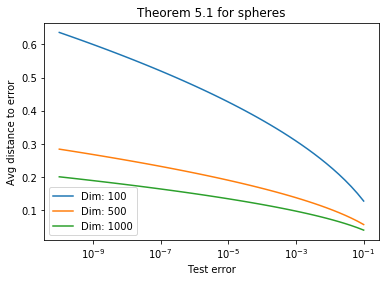

In [16]:
test_dimensions = [100,500,1000]

errors = np.logspace(-10, -1, num = 50)

for dim in test_dimensions:
    plt.semilogx(errors, norm.ppf(1-errors)/np.sqrt(dim), label=f"Dim: {dim}")
plt.xlabel('Test error')
plt.ylabel('Avg distance to error')
plt.title('Theorem 5.1 for spheres')
plt.legend(loc=3);


The theorem seems pretty unforgiving for high dimensional datasets.  Take the case of a sphere with 1000 dimensions.  If we train a model well enough that the test error is one in an thousand, then on average, the distance to the nearest adversarial example will be roughly $0.1$. But if we then train the model such that its test performance vastly improves (maybe with some adversarial-defense based approach), such that the test error drops to only one in ten million, then we haven't even doubled the average distance to an adversarial example!  However, it does seem as though the only way to make the model less susceptible to adversarial attack is to improve its accuracy.  

So much for the theoretical content of the paper.  A burning question is now, in practice, how well do neural networks achieve this bound on the test-error versus avg-distance-to-error?  (or, using the notation of the paper, bound on $\mu(E)$ vs. $d(E)$).  This is part of the the experimental content of the paper, and the answer turns out to be that they do pretty well.  Below is figure 4 of the paper, reproduced with the caption:
<img src="fig4.png" height=300 width=500>

As shown in the figure, the authors tested three different networks.  In two of them, the standard ReLU nonlinearity is used, whereas in another, a pointwise quadratic nonlinearity is used.  Of the ReLU networks, one has depth 2 with 1000 hidden units per layer, whereas the other has depth 8 with 2000 hidden units per layer. The quadratic network has depth 2 with 1000 hidden units per layer.  The architecture of the network seems not to matter too much for this behaviour, though: all three networks get quite close to the optimum bound.

What the paper doesn't address, but would be interesting (and probably very very difficult) to explore, is whether the fact that the optimum bound is not exactly attained means that the there are multiple error regions on the sphere, or just that the error region is deformed from a true spherical cap but is still contiguous.  

## Potential things to investigate

This paper suggests many further things to investigate.  A big question is how close real models are to attaining this bound which is set by the geometry of their data manifolds.  Here are a few things which could be looked at:

* **Relation between $\mu(E)$ and $d(E)$ for an ellipsoid** -- at the end of the day, we would like to know what the fundamental bound between $\mu(E)$ and $d(E)$ is, not for a sphere, but for general high-dimensional manifolds describing real data.  One small step in that direction, which seems tractable numerically if not theoretically,  would be to look at an ellipsoid.  Here, for elongated directions, one should be able to construct sets $E$ such that $d(E)$ is greater than what it would be on a sphere.  This should be doable becuase sampling uniformly from an ellipsoid should be possible by a small extension of the method by which one can sample from a sphere.  

* **Contiguity of error sets for real problems** -- this one sounds quite tough to investigate, but it would be interesting to know whether all or most adversarial examples of a real network are contiguous, i.e. all lie in a connected region of the data manifold.  If this is not the case, then it seems that the network will not come close to attaining the bound imposed by the geometry of the data manifold on $d(E)$ vs. $\mu(E)$. I have no idea how to go about investigating this idea.  

* **Impact of architecture and dimension on attainment of spherical bound** -- In the figure shown above, it seems like all of the three architectures tried seem pretty close to achieving the optimal bound.  How does this vary with the architecture of the network studied and the dimension of the problem?  